In [1]:
"""Data inspection."""

'Data inspection.'

In [2]:
import csv
import glob
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation
import nibabel
import os
import sklearn
import shutil

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

import importlib
import analyze
importlib.reload(analyze)
import datasets
importlib.reload(datasets)
import vis
importlib.reload(vis)
import train_utils
importlib.reload(train_utils)

CRYO_DIR = '/cryo/'
TRAIN_VAL_DIR = os.path.join(CRYO_DIR, 'train_val_datasets')
OUTPUT = '/scratch/users/nmiolane/output_cryo_sim'
DEVICE = 'cuda'

IMG_SHAPE = (128, 128)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)
TRAIN_IMG_PATH = os.path.join(TRAIN_VAL_DIR, 'cryo_sim_%s.npy' % SHAPE_STR)
TRAIN_LABELS_PATH = os.path.join(TRAIN_VAL_DIR, 'cryo_sim_labels_%s.csv' % SHAPE_STR)

Using numpy backend


Loading /cryo/train_val_datasets/cryo_sim_128x128.npy
Dataset shape: (2544, 1, 128, 128)


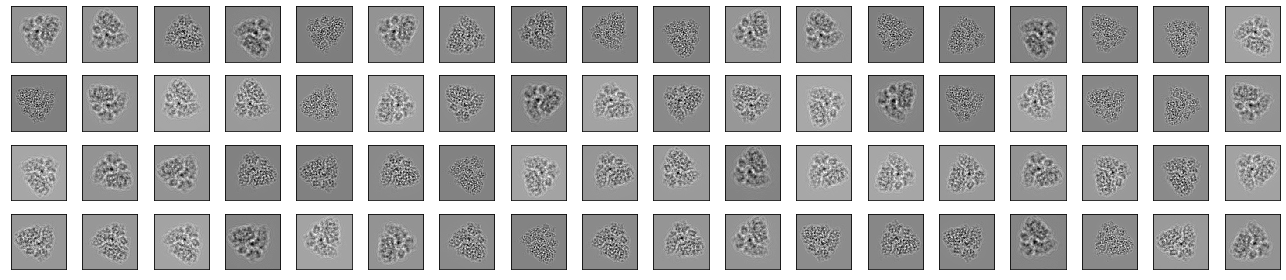

In [3]:
vis.show_data(TRAIN_IMG_PATH)

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_295_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_295_checkpoint.pth.


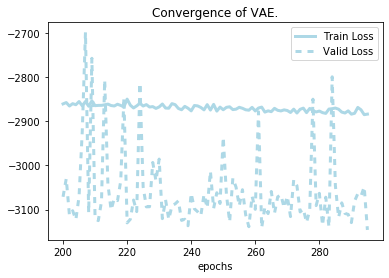

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = vis.plot_convergence(
    ax, OUTPUT, algo_name='vae', crit_name='total', start_epoch_id=200)

# Inspect the latent space

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_295_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_295_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...


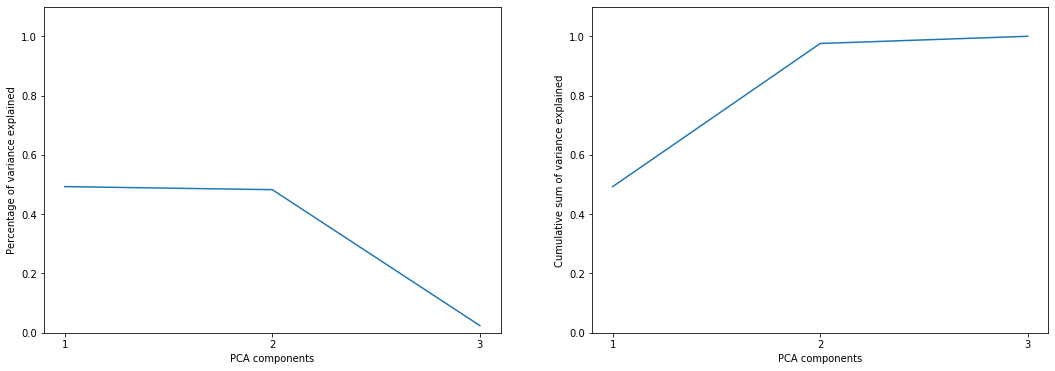

In [5]:
ax = vis.plot_variance_explained(OUTPUT, TRAIN_IMG_PATH)

In [6]:
def get_unexplained_variance(output, dataset_path, variance_name):
    """
    Compute L2 norm between SSD matrices.
    It amounts to the residual variance in the Euclidean space with L2 norm.
    """
    print('Loading %s' % dataset_path)
    img = np.load(dataset_path)
    img = img[:100]
    print('Dataset shape:', img.shape)
    
    recon = vis.get_recon(output, img, algo_name='vae')
    
    if variance_name == 'log_eucl':
        img = train_utils.spd_feature_from_matrix(img, 'log_matrix')
        recon = np.expand_dims(recon, axis=1)
        recon = train_utils.spd_feature_from_matrix(recon, 'log_matrix')
        
    img = np.squeeze(img)
    recon = np.squeeze(recon)
    assert len(recon.shape) == 3
    assert len(img.shape) == 3
    
    ssd = np.sum((img - recon)**2, axis=(1, 2))
    mean_ssd = np.mean(ssd)
    
    mean_img = np.mean(img, axis=0)

    variance = np.mean(np.sum((img - mean_img)**2, axis=(1, 2)))
    
    unexplained_var = mean_ssd / variance
    return unexplained_var

In [12]:
unexplained_var = get_unexplained_variance(
            OUTPUT, dataset_path=TRAIN_IMG_PATH, variance_name='eucl')
print(unexplained_var)

Loading /cryo/train_val_datasets/cryo_sim_128x128.npy
Dataset shape: (100, 1, 128, 128)
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_295_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_295_checkpoint.pth.
Loading decoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_295_checkpoint.pth.
0.19202268


In [11]:
def get_cryo(dataset_path, labels_path, n_pc=2):
    labels = {}
    labels['focus'] = []
    labels['theta'] = []
    with open(labels_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for i_row, row in enumerate(reader):
            if i_row == 0:
                continue
            labels['focus'].append(float(row[0]))
            labels['theta'].append(float(row[1]))
        
    # Note: the test dataset needs to be unshuffled here
    mus = analyze.latent_projection(OUTPUT, dataset_path)
    _, projected_mus = analyze.pca_projection(mus, n_pc)

    return projected_mus, labels

In [12]:
FOCUS_MAX = 3.
start = 0.5
by = 0.5
num = int((FOCUS_MAX - start) / by + 1)
colormap = cm.get_cmap('viridis')
COLORS_FOCUS = colormap(np.linspace(start=0, stop=1, num=num))

start = -180
by = 1
num = 2 * 180 + 1
colormap = cm.get_cmap('twilight')
COLORS_THETA = colormap(np.linspace(start=0, stop=1, num=num))

COLORS = {
    'focus': COLORS_FOCUS,
    'theta': COLORS_THETA
}

def plot_cryo(ax, img_path, labels_path, n_pc=2, label_name='focus'):
    projected_mus, labels = get_cryo(img_path, labels_path, n_pc=n_pc)
    colored_labels = labels[label_name]
    focuses = labels['focus']

    for mu, colored_label, focus in zip(projected_mus, colored_labels, focuses):
        #if label_name == 'theta' and focus != 2.5:
        #    continue
        if label_name == 'focus':
            color_id = int(2 * colored_label) - 1
        elif label_name == 'theta':
            color_id = int((colored_label + 180))
            
        colors = COLORS[label_name]
        if n_pc == 2:
            im = ax.scatter(mu[0], mu[1], c=np.array([colors[color_id]]), s=4)
        else:
            im = ax.scatter(mu[0], mu[1], mu[2], c=np.array([colors[color_id]]))
    return im, ax

# 2D

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_295_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_295_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...


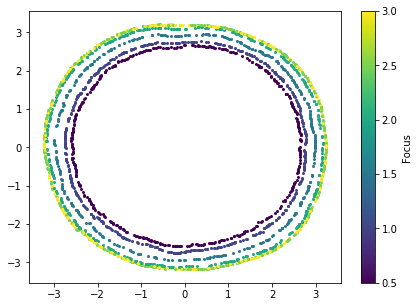

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

im, ax = plot_cryo(ax, TRAIN_IMG_PATH, TRAIN_LABELS_PATH)
cb = fig.colorbar(im, ax=ax)
focus = cb.set_label('Focus')
yticklabels = cb.ax.set_yticklabels(np.arange(start=0.5, stop=3.5, step=0.5))

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_80_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_80_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...


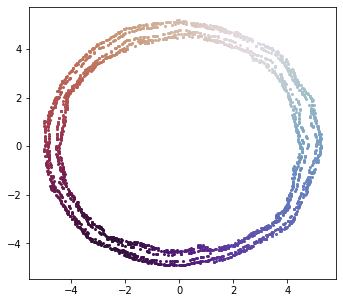

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 5))

im, ax = plot_cryo(ax, TRAIN_IMG_PATH, TRAIN_LABELS_PATH, label_name='theta')

# 3D

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_95_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_95_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...


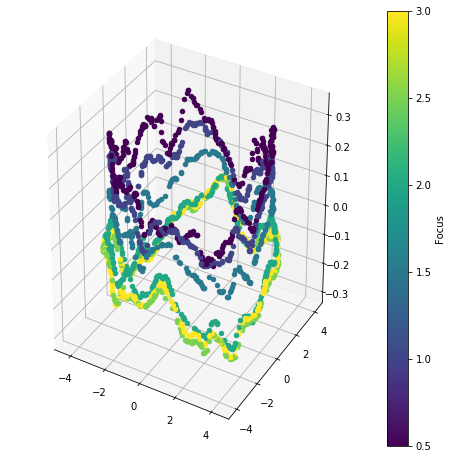

In [43]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(8, 8))#18, 14))
ax = fig.add_subplot(111, projection='3d')

im, ax = plot_cryo(ax, TRAIN_IMG_PATH, TRAIN_LABELS_PATH, n_pc=3)
cb = fig.colorbar(im, ax=ax)
focus = cb.set_label('Focus')
yticklabels = cb.ax.set_yticklabels(np.arange(start=0.5, stop=3.5, step=0.5))

Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_55_checkpoint.pth.
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_55_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...


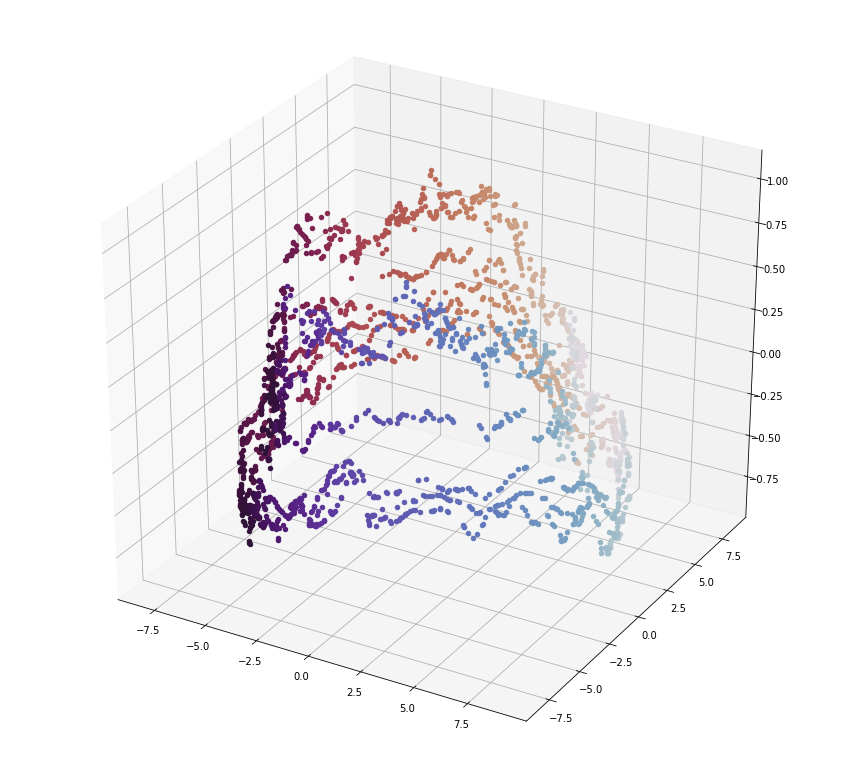

In [33]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(15, 14))
ax = fig.add_subplot(111, projection='3d')

im, ax = plot_cryo(ax, TRAIN_IMG_PATH, TRAIN_LABELS_PATH, n_pc=3, label_name='theta')

# Reconstructions

Shape of img data:
(5, 1, 128, 128)
Shape of recon:
(5, 1, 128, 128)


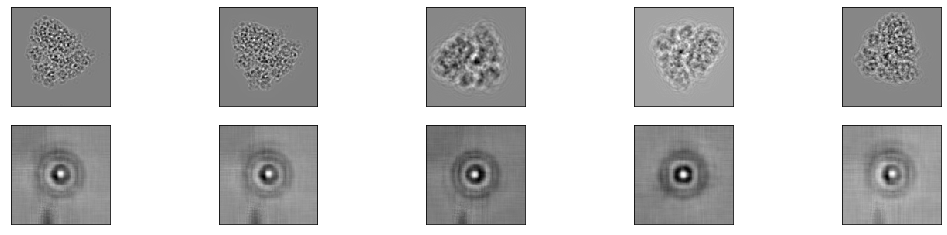

In [301]:
epoch_id = 1
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(5, 1, 128, 128)
Shape of recon:
(5, 1, 128, 128)


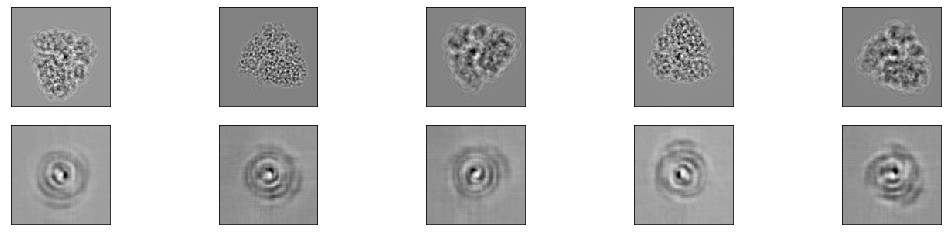

In [302]:
epoch_id = 5
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(5, 1, 128, 128)
Shape of recon:
(5, 1, 128, 128)


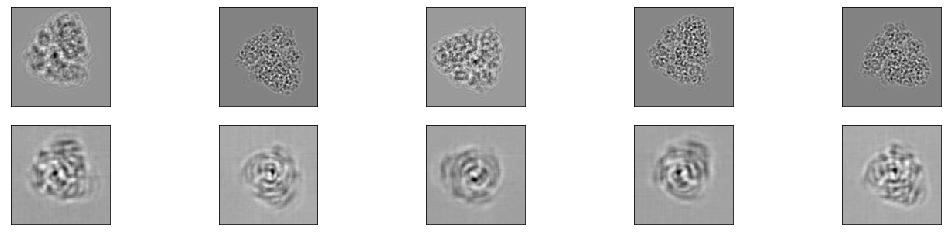

In [303]:
epoch_id = 10
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Shape of img data:
(5, 1, 128, 128)
Shape of recon:
(5, 1, 128, 128)


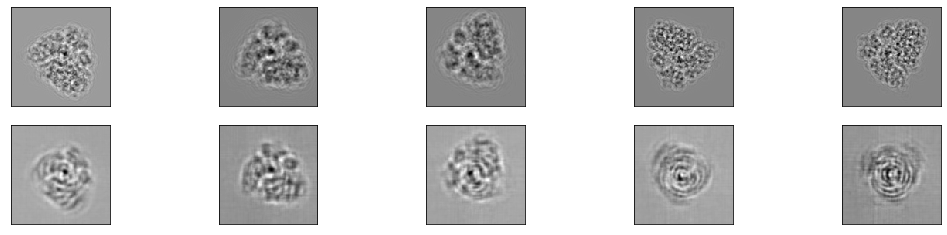

In [304]:
epoch_id = 15
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='gray')

Loading /cryo/train_val_datasets/cryo_sim_128x128.npy
Dataset shape: (2544, 1, 128, 128)
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_55_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_55_checkpoint.pth.
Loading decoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_55_checkpoint.pth.


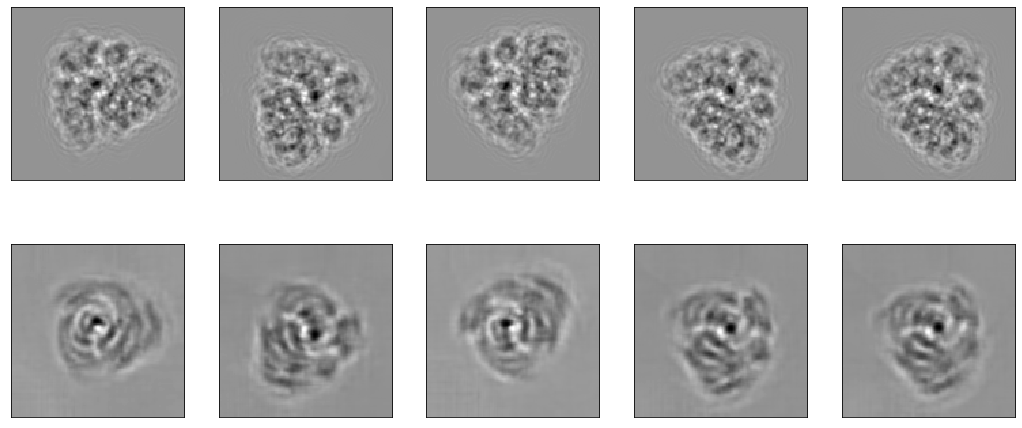

In [49]:
epoch_id = 55
vis.show_img_and_recon(OUTPUT, dataset_path=TRAIN_IMG_PATH, algo_name='vae', epoch_id=epoch_id, cmap='gray')

Loading /cryo/train_val_datasets/cryo_sim_128x128.npy
Dataset shape: (2544, 1, 128, 128)
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_95_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_95_checkpoint.pth.
Loading decoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_95_checkpoint.pth.


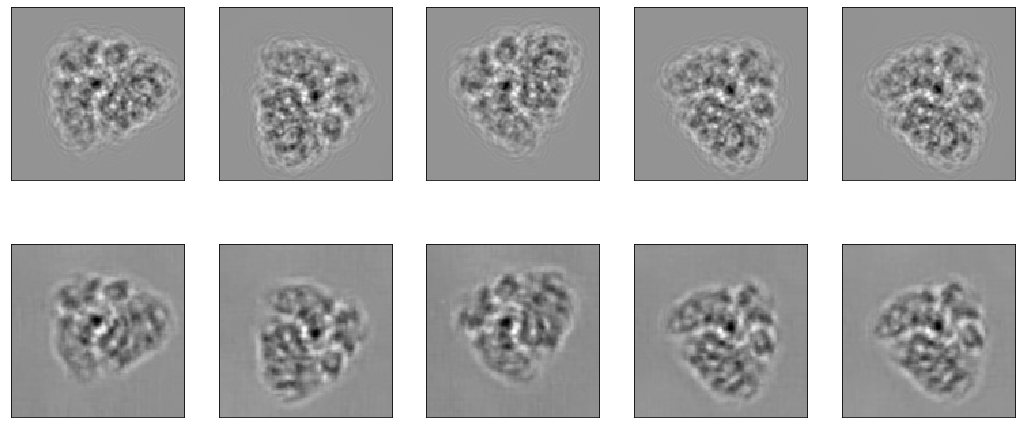

In [47]:
epoch_id = 95
vis.show_img_and_recon(OUTPUT, dataset_path=TRAIN_IMG_PATH, algo_name='vae', epoch_id=epoch_id, cmap='gray')

Loading /cryo/train_val_datasets/cryo_sim_128x128.npy
Dataset shape: (2544, 1, 128, 128)
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_230_checkpoint.pth.
Loading encoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_230_checkpoint.pth.
Loading decoder from network of architecture: conv_plus...
Found checkpoint. Getting: /scratch/users/nmiolane/output_cryo_sim/train_vae/epoch_230_checkpoint.pth.


AssertionError: 

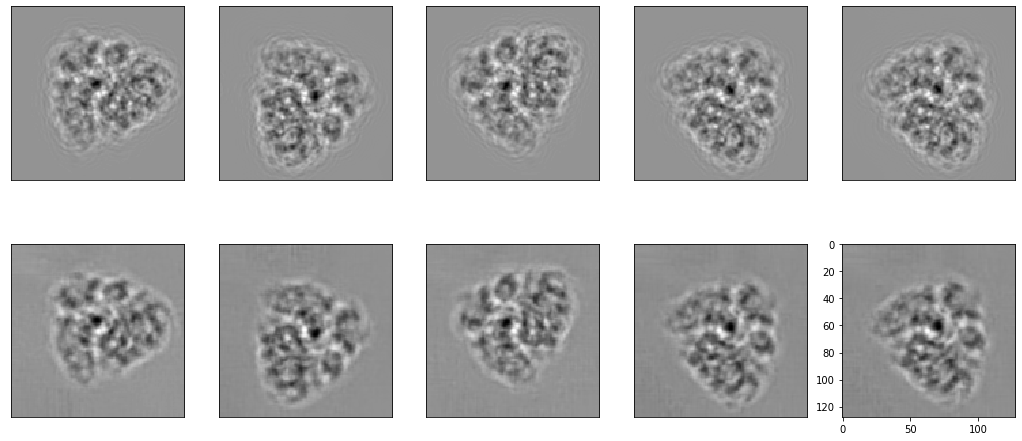

In [64]:
epoch_id = 230
vis.show_img_and_recon(OUTPUT, dataset_path=TRAIN_IMG_PATH, algo_name='vae', epoch_id=epoch_id, cmap='gray')